In [1]:
from typing import List, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import quantstats_lumi as qs
import requests
import math
import utils

from tqdm import tqdm

sns.set_palette(sns.color_palette("hls", 12))

plt.style.use("ggplot")
STARTING_PERIOD = "2014-01-01"

In [2]:
data = pd.read_excel("FTSEMIB_tickers.xlsx")
display(data.head(), data.tail())

,ticker,name,sector
0,ENI.MI,Eni,energy
1,FBK.MI,Finecobank,bank
2,SRG.MI,Snam,energy
3,BMED.MI,Banca Mediolanum,financial_services
4,MB.MI,Mediobanca,financial_services


,ticker,name,sector
35,BC.MI,Brunello Cucinelli,consumer_market
36,INW.MI,Inwit,telecomunications
37,NEXI.MI,Nexi,industrial
38,SPM.MI,Saipem,energy
39,STMMI.MI,Stmicroelectronics,tecnology


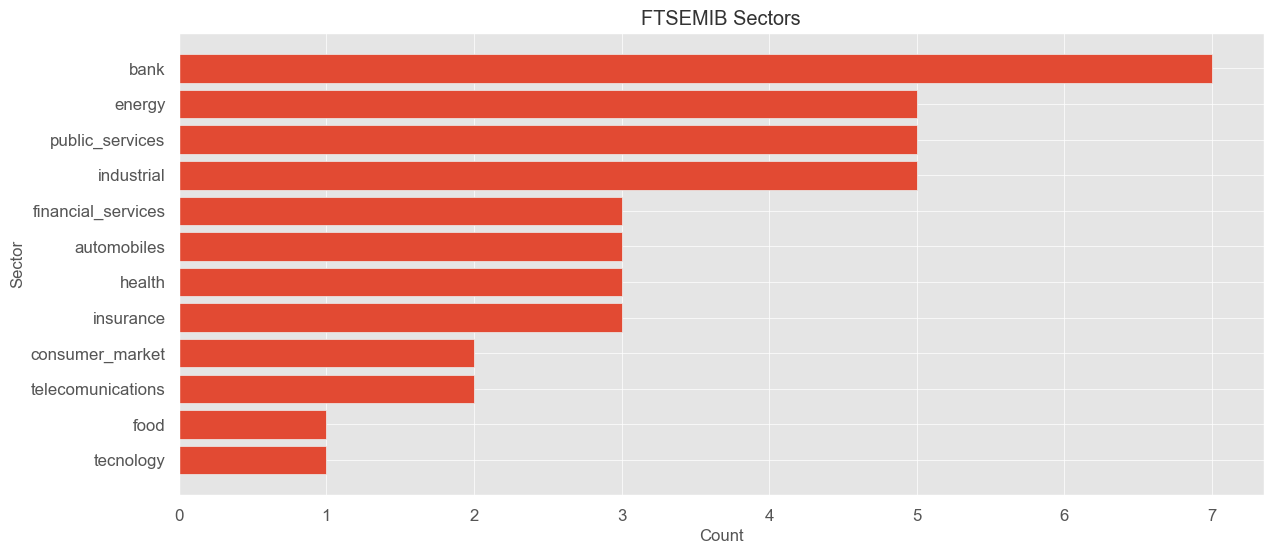

In [3]:
count = data["sector"].value_counts()[::-1]

fig, ax = plt.subplots(figsize=(14, 6))

ax.barh(count.index, count.values)
ax.set_ylabel("Sector")
ax.set_xlabel("Count")
ax.set_title("FTSEMIB Sectors")
plt.show()

In [4]:
previousClose = []
marketCap = []
shares = []

for stock in tqdm(data["ticker"]):
    ticker = yf.Ticker(stock)
    previousClose.append(ticker.fast_info["previousClose"])
    marketCap.append(ticker.fast_info["marketCap"])
    shares.append(ticker.fast_info["shares"])
        
data["previousClose"] = previousClose
data["marketCap"] = marketCap
data["shares"] = shares
data.sort_values(by=["sector", "marketCap"], ascending=[True, False], inplace=True, ignore_index=True)

returns_data = yf.download(tickers=list(data["ticker"]), actions=True).loc[STARTING_PERIOD:]
returns_data.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

100%|██████████| 40/40 [00:13<00:00,  2.98it/s]
[*********************100%%**********************]  39 of 39 completed


In [5]:
avg_return = []
yearly_return = []
volatility = []
max_drawdown = []

for ticker in tqdm(data["ticker"]):
    ret_series = utils.compute_returns(returns_data[("Adj Close", ticker)]).dropna()
    
    avg_return.append(ret_series.mean())
    volatility.append(qs.stats.volatility(ret_series))
    max_drawdown.append(qs.stats.max_drawdown(ret_series))
    yearly_return.append(utils.compute_yearly_compounded_returns(ret_series, prices=False))
    
data["avg_return"] = avg_return
data["yearly_return"] = yearly_return
data["volatility"] = volatility
data["max_drawdown"] = max_drawdown

100%|██████████| 40/40 [00:02<00:00, 18.64it/s]


In [6]:
display(data.head())

,ticker,name,sector,previousClose,marketCap,shares,avg_return,yearly_return,volatility,max_drawdown
0,STLAM.MI,Stellantis,automobiles,25.184999,7.513758e+10,3010319872,0.001143,0.242982,0.455671,-0.658034
1,RACE.MI,Ferrari,automobiles,390.399994,7.047077e+10,180140000,0.001228,0.313639,0.337272,-0.372197
2,PIRC.MI,Pirelli & C,automobiles,5.810000,5.896000e+09,1000000000,0.000258,0.005617,0.415082,-0.602971
3,ISP.MI,Intesa Sanpaolo,bank,3.281500,6.074037e+10,18256799744,0.000682,0.125343,0.395591,-0.541208
4,UCG.MI,Unicredit,bank,34.055000,5.785719e+10,1677020032,0.000534,0.047889,0.504402,-0.801700


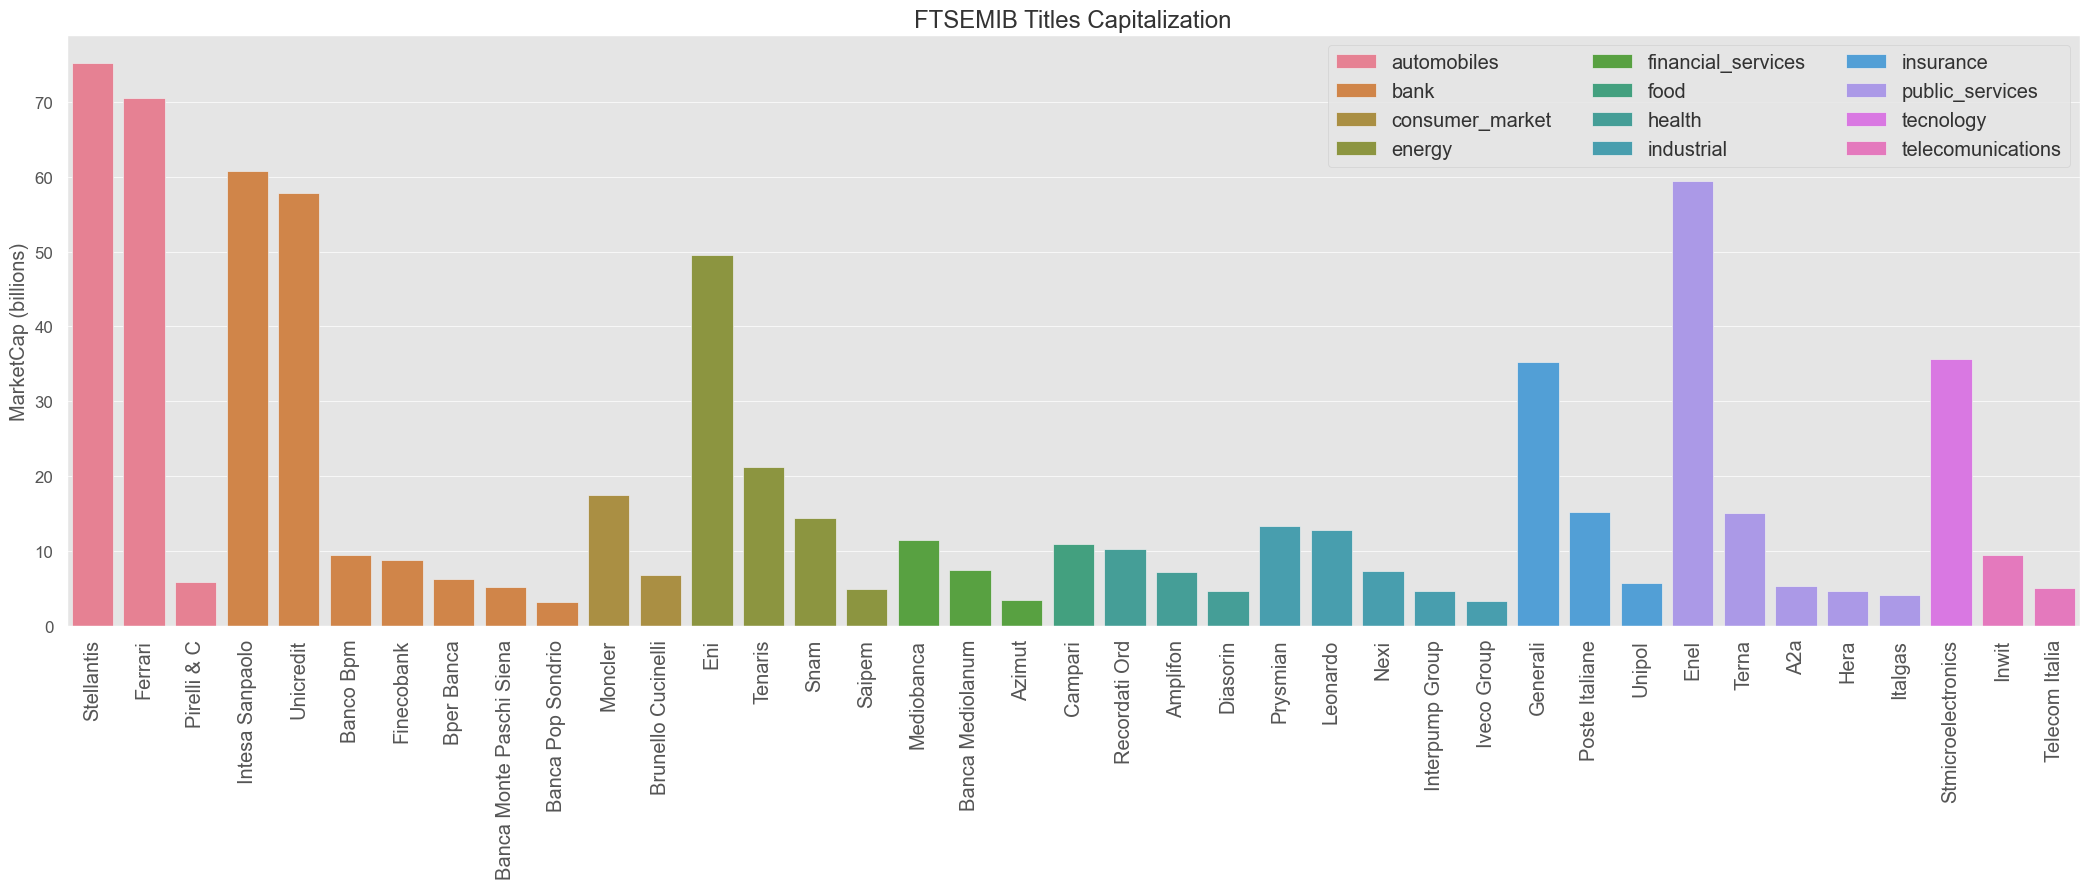

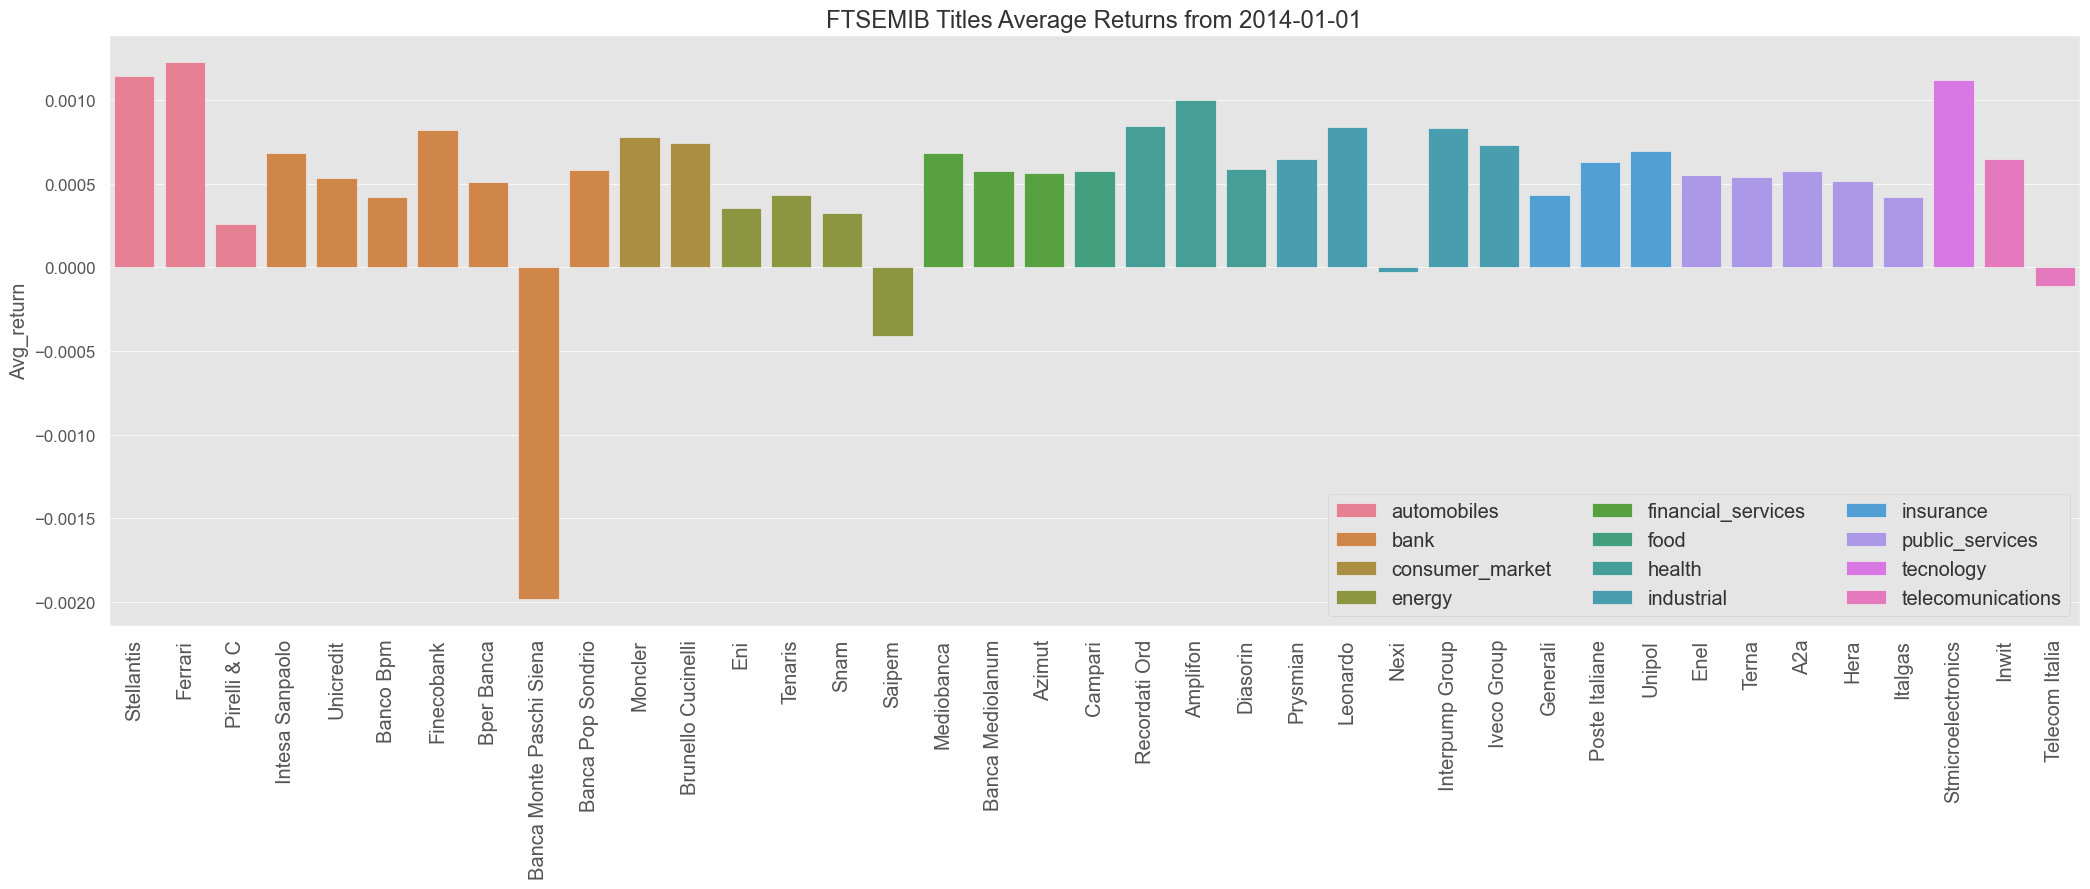

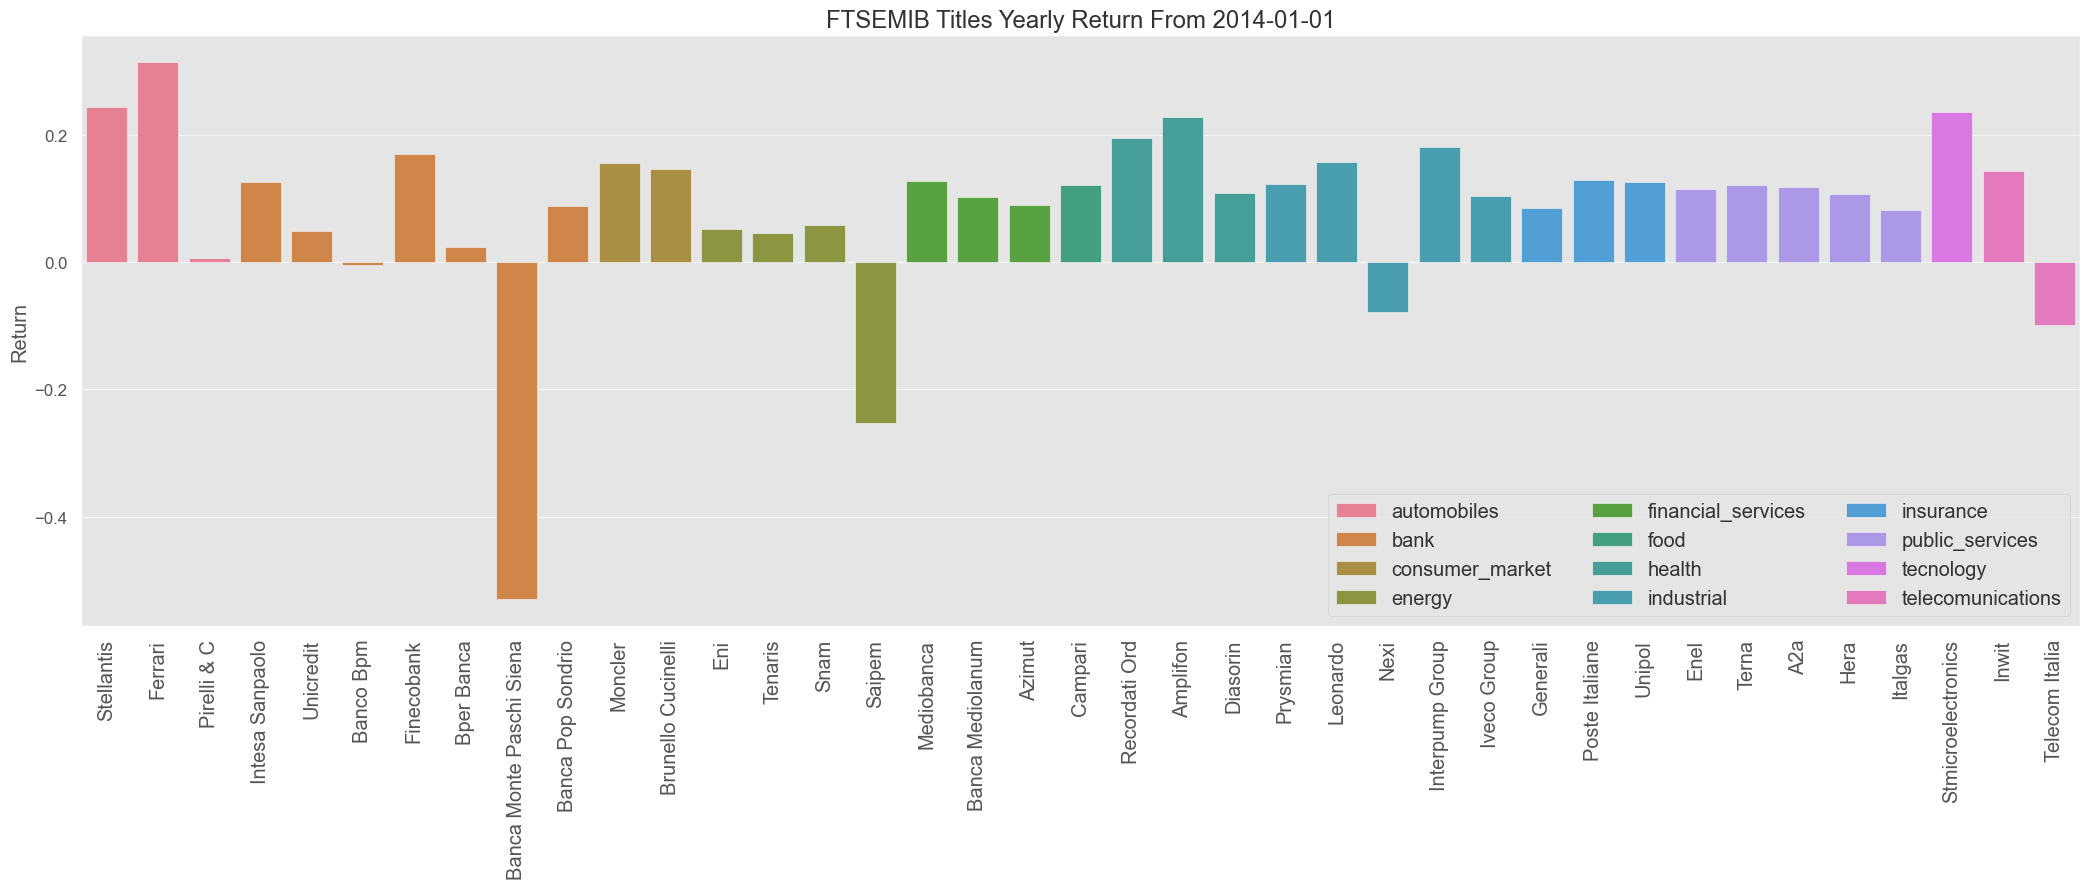

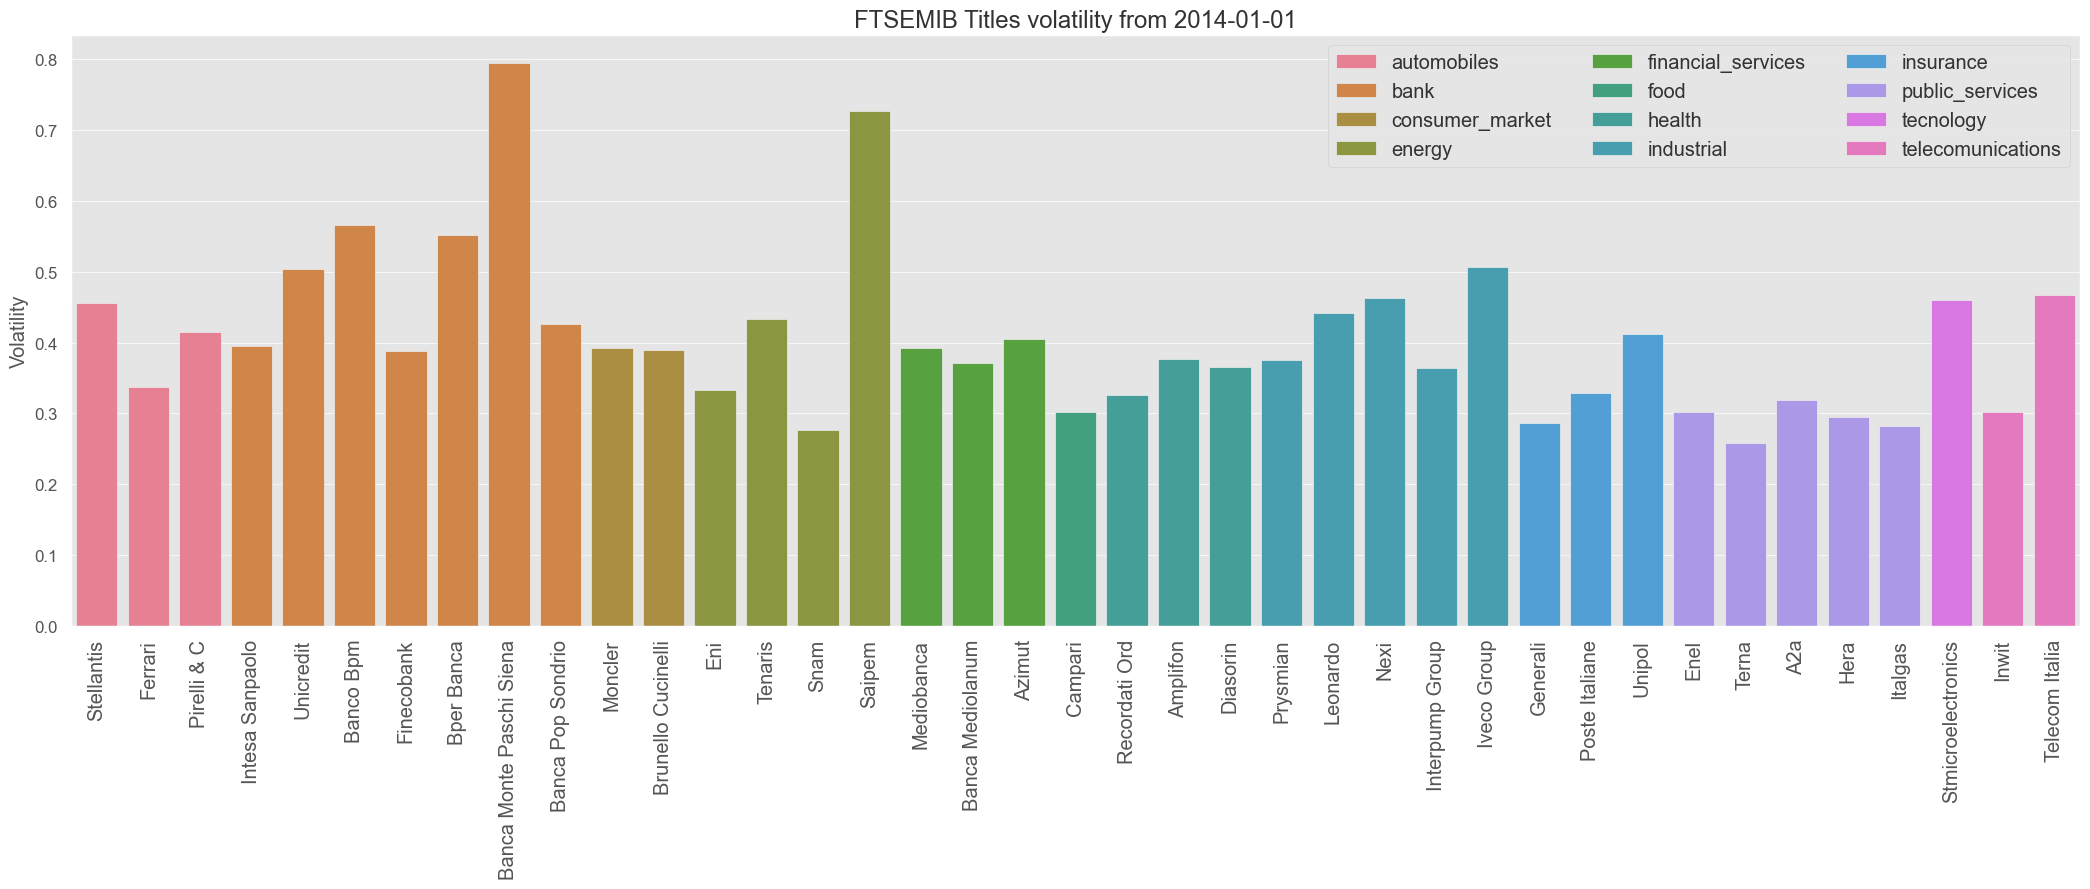

In [7]:
# Plot 1
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=data, x="name", y=data["marketCap"]/1_000_000_000, hue="sector", ax=ax)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("FTSEMIB Titles Capitalization", fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("MarketCap (billions)", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()

# Plot 2
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=data, x="name", y="avg_return", hue="sector", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("FTSEMIB Titles Average Returns from " + STARTING_PERIOD, fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("Avg_return", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()


# Plot 3
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=data, x="name", y="yearly_return", hue="sector", ax=ax)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("FTSEMIB Titles Yearly Return From " + STARTING_PERIOD, fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("Return", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()

# Plot 4
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=data, x="name", y="volatility", hue="sector", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("FTSEMIB Titles volatility from " + STARTING_PERIOD, fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("Volatility", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()

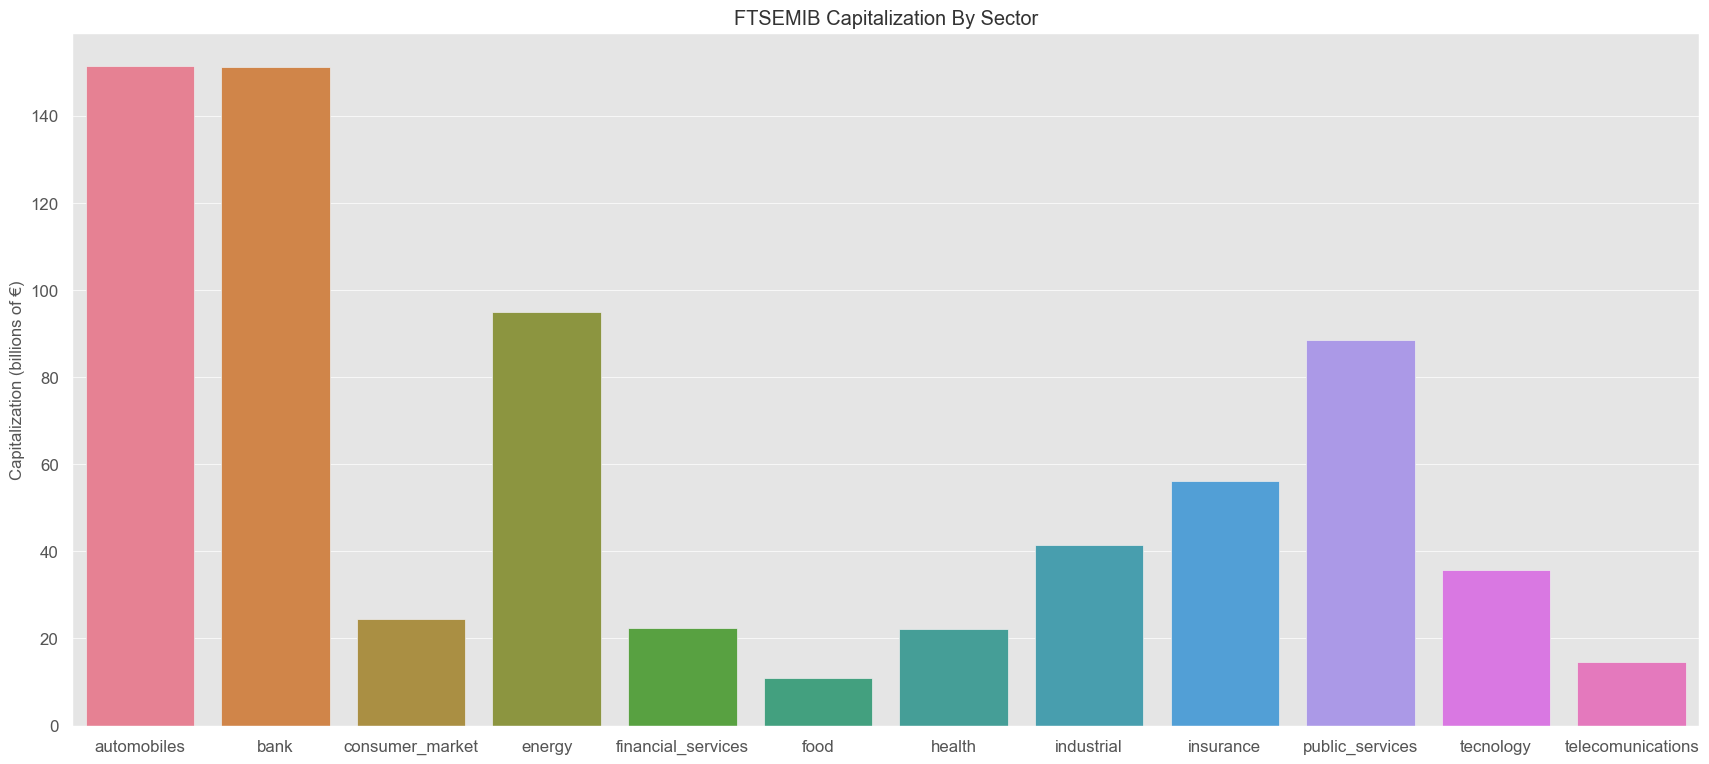

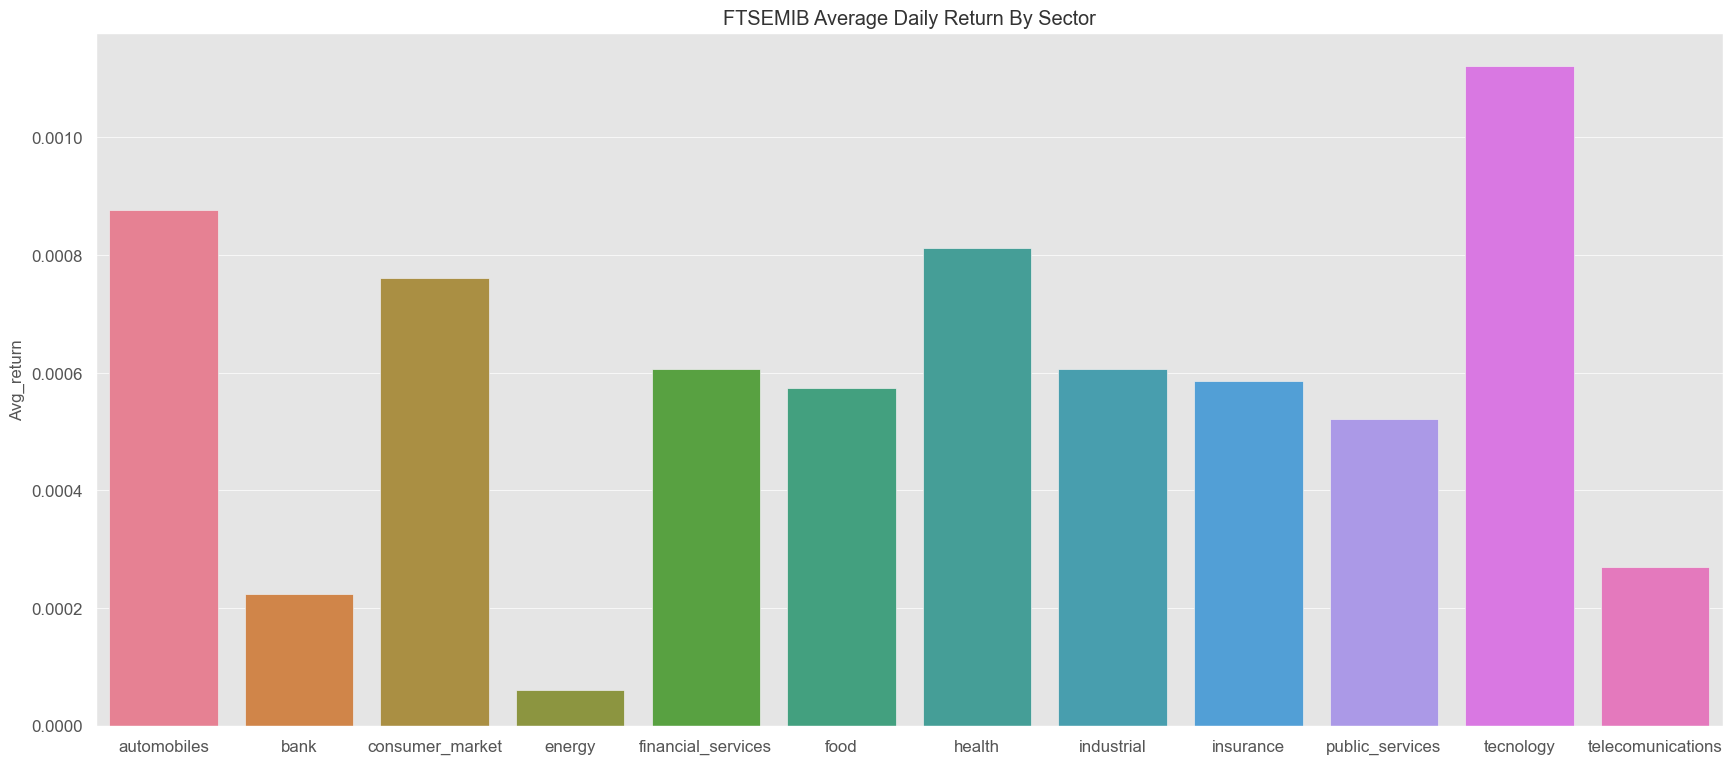

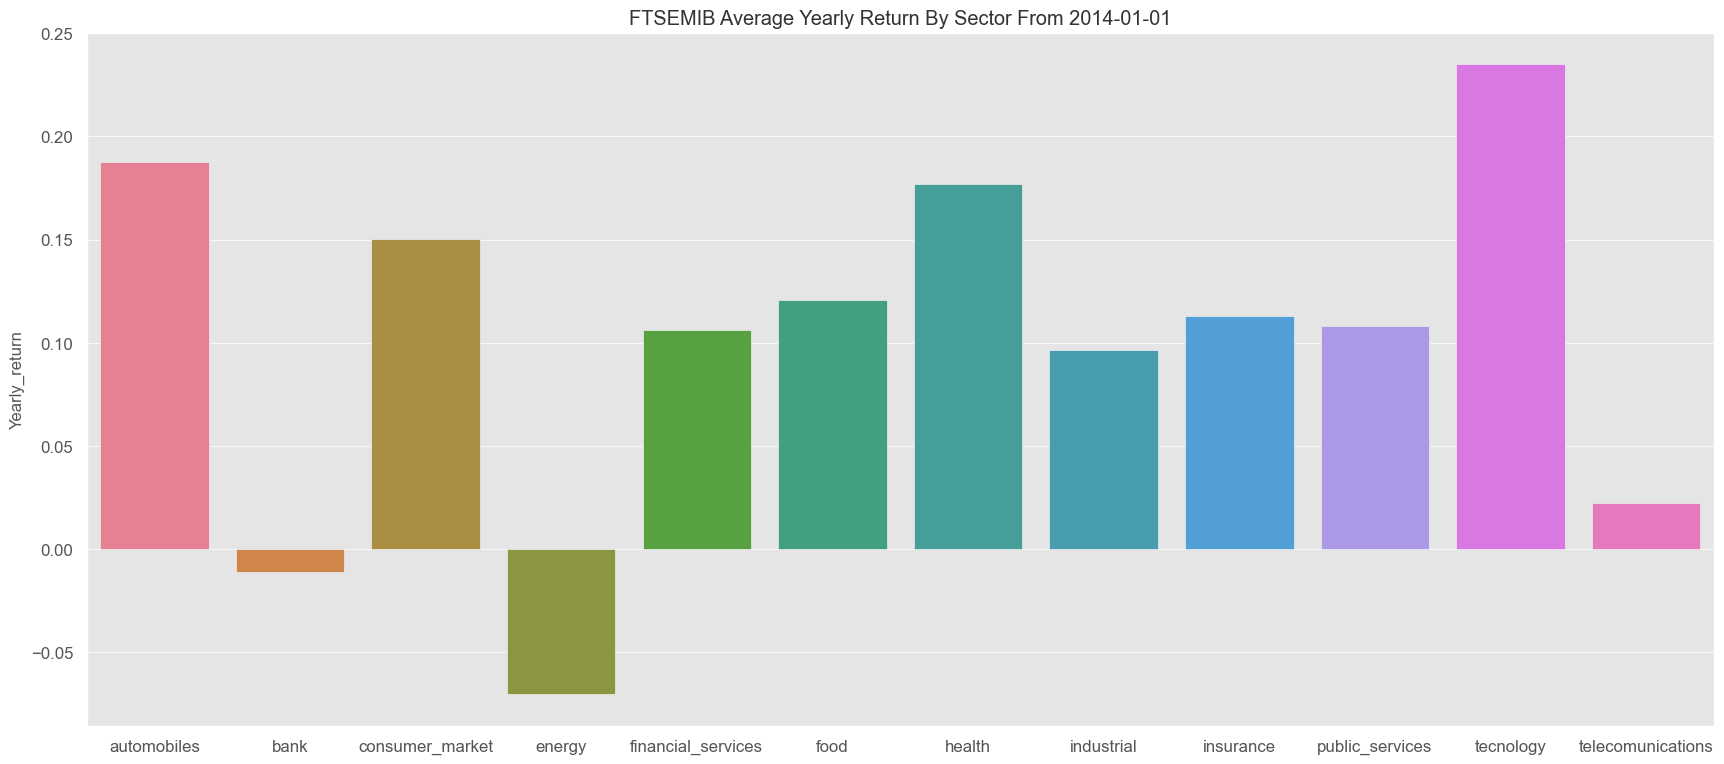

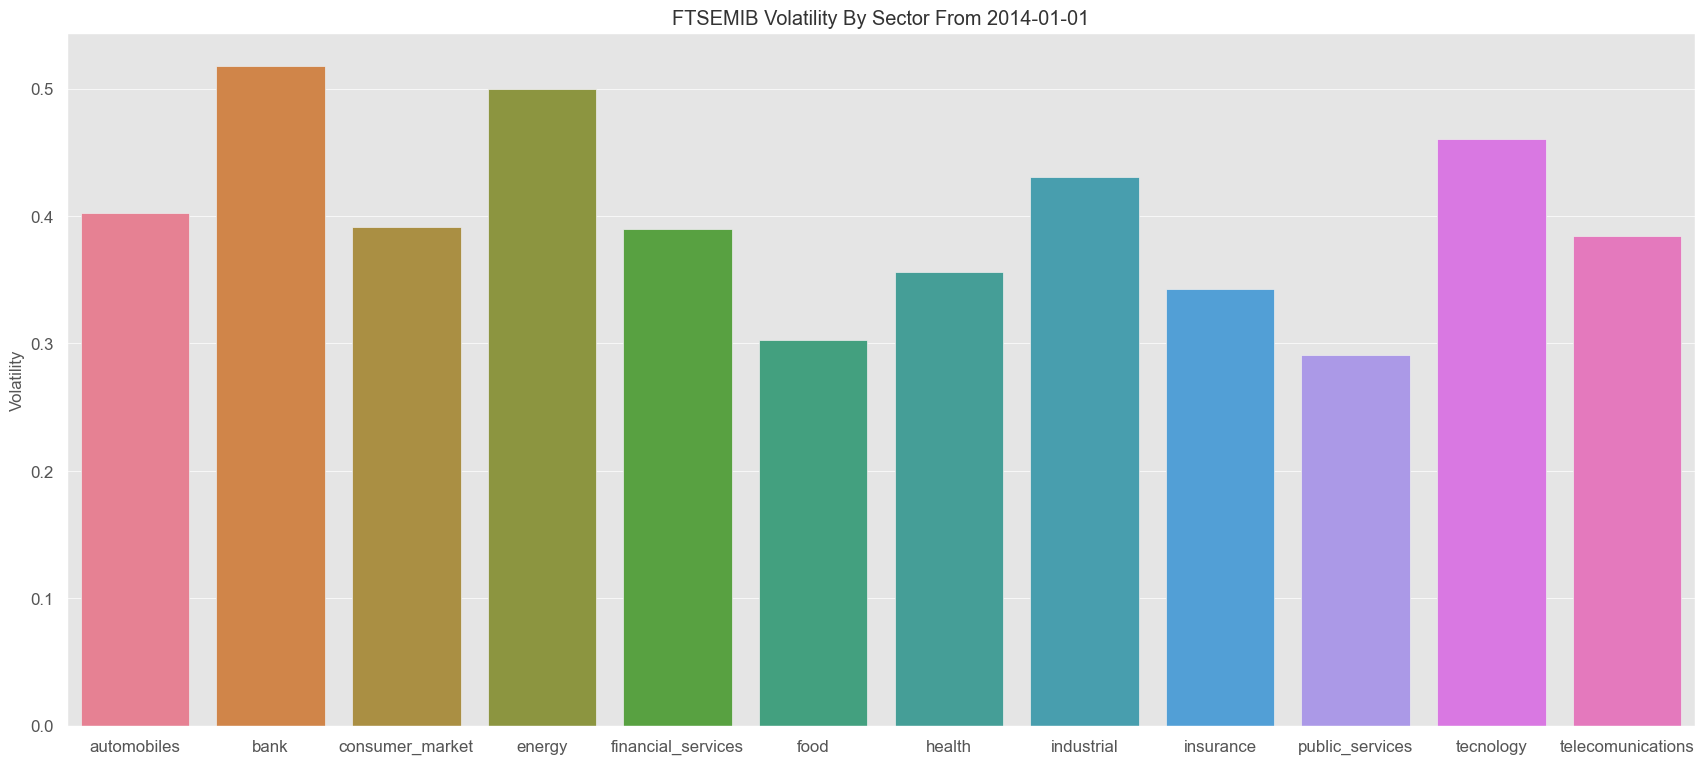

In [17]:
sector_capitalization = data[["sector", "marketCap"]].groupby("sector").sum().sort_values(by="sector", ascending=True)
sector_avg_return = data[["sector", "avg_return"]].groupby("sector").mean().sort_values(by="sector", ascending=True)
sector_volatility = data[["sector", "volatility"]].groupby("sector").mean().sort_values(by="sector", ascending=True)
sector_yearly_return = data[["sector", "yearly_return"]].groupby("sector").mean().sort_values(by="sector", ascending=True)

# Plot 1
fig, ax = plt.subplots(figsize=(21, 9))

sns.barplot(data=sector_capitalization, x="sector", y=sector_capitalization["marketCap"] / 1_000_000_000, hue="sector")
ax.set_xlabel("")
ax.set_ylabel("Capitalization (billions of €)")
ax.set_title("FTSEMIB Capitalization By Sector")
plt.show()

# Plot 2
fig, ax = plt.subplots(figsize=(21, 9))

sns.barplot(data=sector_avg_return, x="sector", y="avg_return", hue="sector")
ax.set_xlabel("")
ax.set_ylabel("Avg_return")
ax.set_title("FTSEMIB Average Daily Return By Sector")
plt.show()

# Plot 3
fig, ax = plt.subplots(figsize=(21, 9))

sns.barplot(data=sector_yearly_return, x="sector", y="yearly_return", hue="sector")
ax.set_xlabel("")
ax.set_ylabel("Yearly_return")
ax.set_title("FTSEMIB Average Yearly Return By Sector From " + STARTING_PERIOD)
plt.show()

# Plot 4
fig, ax = plt.subplots(figsize=(21, 9))

sns.barplot(data=sector_volatility, x="sector", y="volatility", hue="sector")
ax.set_xlabel("")
ax.set_ylabel("Volatility" )
ax.set_title("FTSEMIB Volatility By Sector From " + STARTING_PERIOD)
plt.show()